In [ ]:
# try:
  # This command only in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
import tensorflow as tf

from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D, BatchNormalization, InputLayer, MaxPooling2D #type: ignore
# from tensorflow.keras.preprocessing.image import ImageDataGenerator #type: ignore - ImageDataGenerator is deprecated so image_dataset_from_directory will be used insted 
from tensorflow.keras.preprocessing import image_dataset_from_directory #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, BinaryFocalCrossentropy #type: ignore
from tensorflow.keras.callbacks import Callback #type: ignore
from tensorflow.keras.regularizers import L2 #type: ignore

import os
import numpy as np
import matplotlib.pyplot as plt

2024-12-03 10:47:15.204846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733222835.220622   11283 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733222835.225387   11283 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 10:47:15.241606: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Get project files
# !wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

# !unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
# total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
# total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
# total_test = len(os.listdir(test_dir))

total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 64
epochs = 35
IMG_HEIGHT = 200
IMG_WIDTH = 200
img_size = (IMG_HEIGHT, IMG_WIDTH)

In [ ]:
# 3
# class_names = ['cat', 'dog']
# train_data = image_dataset_from_directory(train_dir,
#                                           labels = 'inferred',
#                                           label_mode = 'int',
#                                           color_mode = 'rgb',
#                                           image_size = img_size,
#                                           batch_size = None,
#                                           class_names = class_names)
# val_data = image_dataset_from_directory(validation_dir,
#                                         labels = 'inferred',
#                                         label_mode = 'int',
#                                         color_mode = 'rgb',
#                                         image_size = img_size,
#                                         batch_size = None,
#                                         class_names = class_names)
# test_data_gen = image_dataset_from_directory(test_dir,
#                                          labels = None,
#                                          color_mode = 'rgb',
#                                          image_size = img_size,
#                                          shuffle = False)

# total = train_data.concatenate(val_data)

# total = total.shuffle(buffer_size = len(total), reshuffle_each_iteration = True)
# train_data_gen = total.take(2000)
# train_data_gen = train_data_gen.batch(batch_size)
# val_data_gen = total.skip(2000).take(1000)
# val_data_gen = val_data_gen.batch(batch_size)

class_names = ['cat', 'dog']
train_data_gen = image_dataset_from_directory(train_dir,
                                          labels = 'inferred',
                                          label_mode = 'int',
                                          color_mode = 'rgb',
                                          image_size = img_size,
                                          batch_size = batch_size,
                                          class_names = class_names)
val_data_gen = image_dataset_from_directory(validation_dir,
                                        labels = 'inferred',
                                        label_mode = 'int',
                                        color_mode = 'rgb',
                                        image_size = img_size,
                                        batch_size = batch_size,
                                        class_names = class_names)
test_data_gen = image_dataset_from_directory(test_dir,
                                         labels = None,
                                         color_mode = 'rgb',
                                         image_size = img_size,
                                         shuffle = False)


Found 2000 files belonging to 2 classes.


I0000 00:00:1733222836.918766   11283 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7908 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:2d:00.0, compute capability: 8.9


Found 1000 files belonging to 2 classes.
Found 50 files.


2024-12-03 10:47:18.555269: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-03 10:47:18.675642: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-03 10:47:18.879934: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


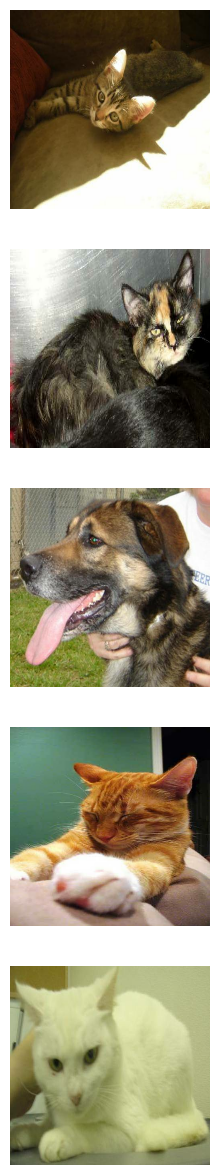

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip(images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

def sample_images_arr(dataset, num_images = 5):
    ds_list = list(dataset.unbatch().as_numpy_iterator())
    random_list = np.random.randint(0, len(ds_list) - num_images - 1, num_images).tolist()

    img_arr = []
    for i in random_list:
        for image, label in dataset.unbatch().skip(i).take(1):
            image = image.numpy().astype('uint8')
            img_arr.append(image)
    
    return img_arr

img_arr = sample_images_arr(train_data_gen)     
plotImages(img_arr)


In [ ]:
# 5
def data_augmentation(dataset):
    def flip_horizontal(image, label):
        image = tf.image.random_flip_left_right(image)
        return tf.image.resize(image, (img_size)), label
    
    def random_contrast(image, label):
        image = tf.image.random_contrast(image, 0.1, 0.6)
        return tf.image.resize(image, (img_size)), label
    
    def random_brightness(image, label):
        image = tf.image.random_brightness(image, max_delta = 0.15)
        return tf.image.resize(image, (img_size)), label
    
    def central_crop(image, label):
        image = tf.image.central_crop(image, central_fraction = 0.7)
        return tf.image.resize(image, (img_size)), label
    
    def random_hue(image, label):
        image = tf.image.random_hue(image, 0.15)
        return tf.image.resize(image, (img_size)), label
    
    def random_saturation (image, label):
        image = tf.image.random_saturation(image, 2, 15)
        return tf.image.resize(image, (img_size)), label
        
    ds = dataset.map(flip_horizontal)
    return_ds = dataset.concatenate(ds)
    ds = dataset.map(random_contrast)
    return_ds = return_ds.concatenate(ds)
    ds = dataset.map(random_brightness)
    return_ds = return_ds.concatenate(ds)
    ds = dataset.map(central_crop)
    return_ds = return_ds.concatenate(ds)
    ds = dataset.map(random_hue)
    return_ds = return_ds.concatenate(ds)
    ds = dataset.map(random_saturation)
    return_ds = return_ds.concatenate(ds)
    
    return return_ds

train_data_gen = data_augmentation(train_data_gen)


In [ ]:
# 6
# train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
#                                                      directory=train_dir,
#                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
#                                                      class_mode='binary')

# augmented_images = [train_data_gen[0][0][0] for i in range(5)]
new_img_arr = sample_images_arr(train_data_gen, num_images = 5)

plotImages(new_img_arr)

In [ ]:
# 7
model = Sequential([InputLayer(shape = (IMG_WIDTH, IMG_HEIGHT, 3)),
                    Conv2D(filters = 64, kernel_size = 8, strides = 1, padding = 'same', activation = 'relu', kernel_regularizer = L2(0.015)),
                    BatchNormalization(),
                    MaxPool2D(pool_size = 4),
                    Conv2D(filters = 32, kernel_size = 8, strides = 1, padding = 'same', activation = 'relu', kernel_regularizer = L2(0.015)),
                    BatchNormalization(),
                    MaxPool2D(pool_size = 4),
                    Conv2D(filters = 8, kernel_size = 4, strides = 1, padding = 'same', activation = 'relu', kernel_regularizer = L2(0.015)),
                    BatchNormalization(),
                    MaxPool2D(pool_size = 2),
                    Dropout(rate = 0.4),
                    Flatten(),
                    Dense(units = 128, activation = 'relu'),
                    Dense(units = 1, activation = 'sigmoid')])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 200, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 8)      │         4,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,097 (723.04 KB)

 Trainable params: 184,889 (722.22 KB)

 Non-trainable params: 208 (832.00 B)

In [ ]:
# 8
class CustomLearningRateScheduler(Callback):
    def __init__(self, patience, factor, min_lr):
        super(CustomLearningRateScheduler, self).__init__()
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.wait = 0  
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs = None):
        logs = logs or {}
        val_acc = logs.get('val_accuracy')
        val_prec = logs.get('val_precision')
        val_loss = logs.get('val_loss')
        if val_acc is not None:
            if val_loss < self.best_val_loss + 0.005:
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    current_lr = float(self.model.optimizer.learning_rate)
                    new_lr = max(current_lr * self.factor, self.min_lr)
                    if current_lr > self.min_lr:
                        print(f"\nEpoch {epoch + 1}: Reducing learning rate from {current_lr:.4f} to {new_lr:.4f}")
                        self.model.optimizer.learning_rate.assign(new_lr)
                    else:
                        print(f"\nEpoch {epoch + 1}: Reducing learning rate from {current_lr:.4f} to {self.min_lr}")
                        self.model.optimizer.learning_rate.assign(self.min_lr)
                    self.wait = 0
                
learning_rate_scheduler = CustomLearningRateScheduler(2, 0.8, 0.0001)

model.compile(optimizer = Adam(learning_rate = 0.001), loss = BinaryCrossentropy(), metrics = ['accuracy', 'recall'])
history = model.fit(train_data_gen, validation_data = val_data_gen, epochs = epochs, verbose = 1, callbacks = [learning_rate_scheduler])

Epoch 1/35


I0000 00:00:1733222895.153766   11382 service.cc:148] XLA service 0x3f6bebd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733222895.153804   11382 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-12-03 10:48:15.221017: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733222895.427223   11382 cuda_dnn.cc:529] Loaded cuDNN version 90501


  3/224 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.5538 - loss: 1.9377 - recall: 0.5475

I0000 00:00:1733222902.120752   11382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


224/224 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.5928 - loss: 1.4928 - recall: 0.5957 - val_accuracy: 0.6510 - val_loss: 0.9039 - val_recall: 0.6940
Epoch 2/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.6842 - loss: 0.8401 - recall: 0.6798 - val_accuracy: 0.5810 - val_loss: 0.8883 - val_recall: 0.2140
Epoch 3/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7261 - loss: 0.6863 - recall: 0.7188 - val_accuracy: 0.5970 - val_loss: 0.8486 - val_recall: 0.2660
Epoch 4/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.7539 - loss: 0.6215 - recall: 0.7407 - val_accuracy: 0.5410 - val_loss: 1.0208 - val_recall: 0.0840
Epoch 5/35
223/224 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7674 - loss: 0.5906 - recall: 0.7540
Epoch 5: Reducing learning rate from 0.0010 to 0.0008
224/224 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.7673 - loss: 0.5907 - recall: 0.7538 - val_accuracy: 0.5670 - val_loss: 1.0275 - val_recall: 0.1540
Epoch 6/35
224/224 ━━━━━

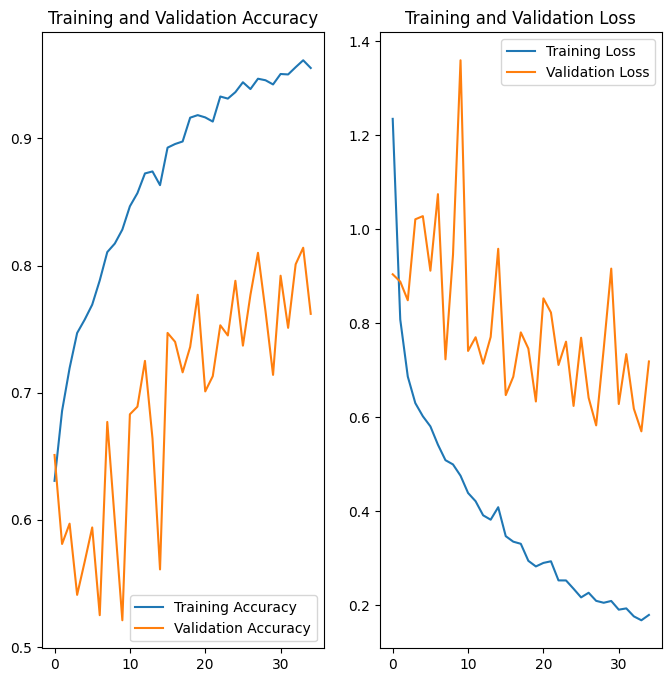

In [8]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
probabilities = model.predict(test_data_gen)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
50


/tmp/ipykernel_11283/1330845568.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
/tmp/ipykernel_11283/1330845568.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")


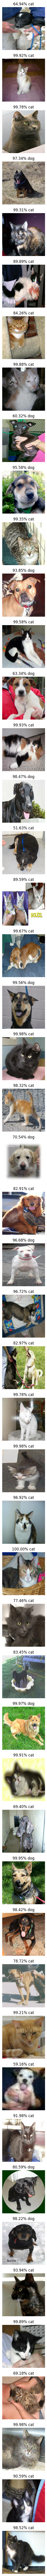

In [ ]:
def test_images_arr(dataset):
    ds_list = list(dataset.unbatch().as_numpy_iterator())
    
    img_arr = []
    for image in ds_list:
        image = image.astype('uint8')
        img_arr.append(image)
    
    return img_arr

prob_img_arr = test_images_arr(test_data_gen)

print(len(prob_img_arr))

plotImages(prob_img_arr, probabilities = probabilities)

In [12]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 80.0% of the images of cats and dogs.
You passed the challenge!
